In [1]:
import scipy.io
import pickle 
import scipy.ndimage
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
import matplotlib.pyplot as plt
from functools import partial
import itertools

import torch
from Solver import *
# from NeuralNet import *
from timeit import default_timer


import sys
sys.path.append('../Utility')
import NeuralNet
import Numerics
import PlotDefault

# diffusivity is a quadratic function
 $$D(\theta) = \sqrt{\theta^2 + (\frac{\partial \theta}{\partial x})^2}$$

In [2]:
L = 1.0
Ny = 100
yy = np.linspace(0.0, L, Ny)
dy = yy[1] - yy[0]
f = -np.ones_like(yy)
dbc = np.array([0.0, 0.0]) 

GENERATE_DATA = False
if GENERATE_DATA:
    # Training data
    xx, f, q, q_c, dq_c = generate_data()

    # Test data
    def f_func1(xx_test):
        return 6*(1-2*xx_test)**2 - 2*(xx_test - xx_test**2)*(1 - 2*xx_test)**2 + 2*(xx_test - xx_test**2)**2 + 2
    def f_func2(xx_test):
        f = np.ones_like(xx_test)
        f[xx_test <= 0.5] = 0.0
        f[xx_test > 0.5] = 10.0
        return f
    def f_func3(xx_test):
        L = 1
        return 10*np.sin(2*np.pi*xx_test/L)

    f_funcs = [f_func1, f_func2, f_func3]
    xx_test, f_test, q_test, q_c_test, dq_c_test = np.zeros((3, Ny)), np.zeros((3, Ny)), np.zeros((3, Ny)), np.zeros((3, Ny-1)), np.zeros((3, Ny-1))

    for i in range(3):
        f_func = f_funcs[i]
        xx_test[i,:], f_test[i,:], q_test[i,:], q_c_test[i,:], dq_c_test[i,:] = generate_data_helper(permeability_ref, f_func, L=1.0, Nx = 100)
    
    
    data_dict = {'xx': xx, 'f': f, 'q': q, 'xx_test': xx_test, 'f_test': f_test, 'q_test': q_test}
    pickle.dump(data_dict, open("data.pickle", 'wb'))
else:
    data_dict = pickle.load(open("data.pickle",'rb'))   
    xx, f, q = data_dict["xx"], data_dict["f"], data_dict["q"]
    xx_test, f_test, q_test = data_dict["xx_test"], data_dict["f_test"], data_dict["q_test"]


In [3]:
dq = np.copy(q)
ddq = np.copy(q)
for i in range(q.shape[0]):
    dq[i, :]  = Numerics.gradient_first(q[i,:], dy, bc = "one-sided")
    ddq[i, :] = Numerics.gradient_second(q[i,:], dy, bc = "one-sided")
 
dq_test = np.copy(q_test)
ddq_test = np.copy(q_test)
for i in range(q_test.shape[0]):
    dq_test[i, :]  = Numerics.gradient_first(q_test[i,:], dy, bc = "one-sided")
    ddq_test[i, :] = Numerics.gradient_second(q_test[i,:], dy, bc = "one-sided")
  
mu, flux, source = np.copy(q), np.copy(q), np.copy(q)
for i in range(q.shape[0]):
    mu[i,:], flux[i,:], source[i,:] = permeability_ref(np.vstack((q[i,:], dq[i,:])).T), flux_ref(np.vstack((q[i,:], dq[i,:])).T), source_ref_q(q[i,:], dy)
    
mu_test, flux_test, source_test = np.copy(q_test), np.copy(q_test), np.copy(q_test)
for i in range(q_test.shape[0]):
    mu_test[i,:], flux_test[i,:], source_test[i,:] = permeability_ref(np.vstack((q_test[i,:], dq_test[i,:])).T), flux_ref(np.vstack((q_test[i,:], dq_test[i,:])).T), source_ref_q(q_test[i,:], dy)


In [4]:
# polynomial orders in nps, nps[0] = 0
def generate_feature(nps, *arg):
    assert(nps[0] == 0)
    
    nf = len(arg)
    nd = len(arg[0])
    
    # generate powers
    powers = list(itertools.product(nps, repeat=nf))
    
    dic = []
    for indp in range(len(powers)):
        cpower = powers[indp]
#         if all(p == 0 for p in cpower):
#             continue
            
        feature = np.ones(nd)
        for i in range(nf):
            feature *= arg[i]**cpower[i]
        dic.append(feature)
    
    # TODO
#     dic.append(np.ones(nd))
        
    return np.vstack(dic).T, powers

nps = [0,1,2,3]



def generate_feature_powers(powers, *arg):
    nf = len(arg)
    nd = len(arg[0])
    dic = []
    for indp in range(len(powers)):
        cpower = powers[indp]
            
        feature = np.ones(nd)
        for i in range(nf):
            feature *= arg[i]**cpower[i]
        dic.append(feature)
    
    return np.vstack(dic).T


In [21]:
# Sparse training 
for nn_save_name in ["diffusivity.dic", "flux.dic", "source.dic"]:
    print("start train nn : ", nn_save_name)
    if nn_save_name == "diffusivity.dic":
        x_train = generate_feature(nps, q.flatten(), dq.flatten())
        y_train = mu.flatten()[:,np.newaxis]

    elif nn_save_name == "flux.dic":
        x_train = generate_feature(nps, q.flatten(), dq.flatten())
        y_train = flux.flatten()[:,np.newaxis]
        
    elif nn_save_name == "source.dic":
        x_train = generate_feature(nps, q.flatten(), dq.flatten(), ddq.flatten())
        y_train = source.flatten()[:,np.newaxis]
    else:
        print("nn_save_name : ", nn_save_name, " is not recognized")
    

x_train, powers = generate_feature(nps, q.flatten(), dq.flatten())
y_train = mu.flatten()[:,np.newaxis]

theta, residuals, rank, s = np.linalg.lstsq(x_train, y_train, rcond=None)


nd = len(x_train[0, :])
x_ind = np.ones(nd, dtype=bool)

converge = False
threshold, rel_threshold = 1e-3, 1e-2
theta_to_x_ind = np.zeros(nd, dtype=int)
while not converge:
    theta_ind_smallest, theta_ind_largest = np.argmin(np.abs(theta)), np.argmax(np.abs(theta))
    print("theta smallest = ", theta[theta_ind_smallest], "theta largest = ", theta[theta_ind_largest])
    if np.abs(theta[theta_ind_smallest])<threshold or np.abs(theta[theta_ind_smallest])<rel_threshold*np.abs(theta[theta_ind_largest]):
        
        #theta_to_x_ind[i] = the i-th 1 in x_ind
        
        
        j = 0
        for i in range(nd):
            if x_ind[i]:
                theta_to_x_ind[j] = i
                j += 1
        
        print("remove the index : ", theta_to_x_ind[theta_ind_smallest], powers[theta_to_x_ind[theta_ind_smallest]])
        
        x_ind[theta_to_x_ind[theta_ind_smallest]] = False
        
        
        
        theta, residuals, rank, s = np.linalg.lstsq(x_train[:, x_ind], y_train, rcond=None)
    else:
        converge = True
        
theta = theta.flatten()
powers = list(itertools.compress(powers, x_ind))
print("theta: ",          theta)
print("powers: ",         list(powers))




start train nn :  diffusivity.dic
start train nn :  flux.dic
start train nn :  source.dic
theta smallest =  [-0.09364195] theta largest =  [6.25304271]
theta:  [ 0.42161802 -0.09364195  0.55684104  0.09642206 -1.39789576  0.16596054
  1.28098721  0.25638655  5.93816582  0.15770307 -4.68185915 -1.65594749
 -5.74489054 -0.29588783  6.25304271  1.97730941]
powers:  [(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


In [22]:
ind = len(theta)
outd = y_train.shape[1] 
bias = False
trained_net = NeuralNet.FNN(ind, outd, 1, width, activation, initializer, outputlayer, bias) 

trained_net.modus['LinMout'].weight = torch.nn.parameter.Parameter(torch.from_numpy(theta.reshape((outd, -1)).astype(np.float32)))

print(trained_net.modus['LinMout'].weight)
print(trained_net.modus['LinMout'].bias)

Parameter containing:
tensor([[ 0.4216, -0.0936,  0.5568,  0.0964, -1.3979,  0.1660,  1.2810,  0.2564,
          5.9382,  0.1577, -4.6819, -1.6559, -5.7449, -0.2959,  6.2530,  1.9773]],
       requires_grad=True)
None


In [23]:
# nn_save_name = "diffusivity.dic"
# trained_net = torch.load(nn_save_name)


# # print(trained_net.modus['LinM{}'.format(1)].weight)
# # print(trained_net.modus['LinM{}'.format(1)].bias)
# print(trained_net.modus['LinMout'].weight)
# print(trained_net.modus['LinMout'].bias)

/tmp/ipykernel_185567/2656609694.py:51: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im0=ax[0].pcolormesh(X_test_2d, Y_test_2d, y_test_2d, vmin=vmin, vmax=vmax)
/tmp/ipykernel_185567/2656609694.py:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1=ax[1].pcolormesh(X_test_2d, Y_test_2d, y_pred_2d, vmin=vmin, vmax=vmax)
/tmp/ipykernel_185567/2656609694.py:59: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is depreca

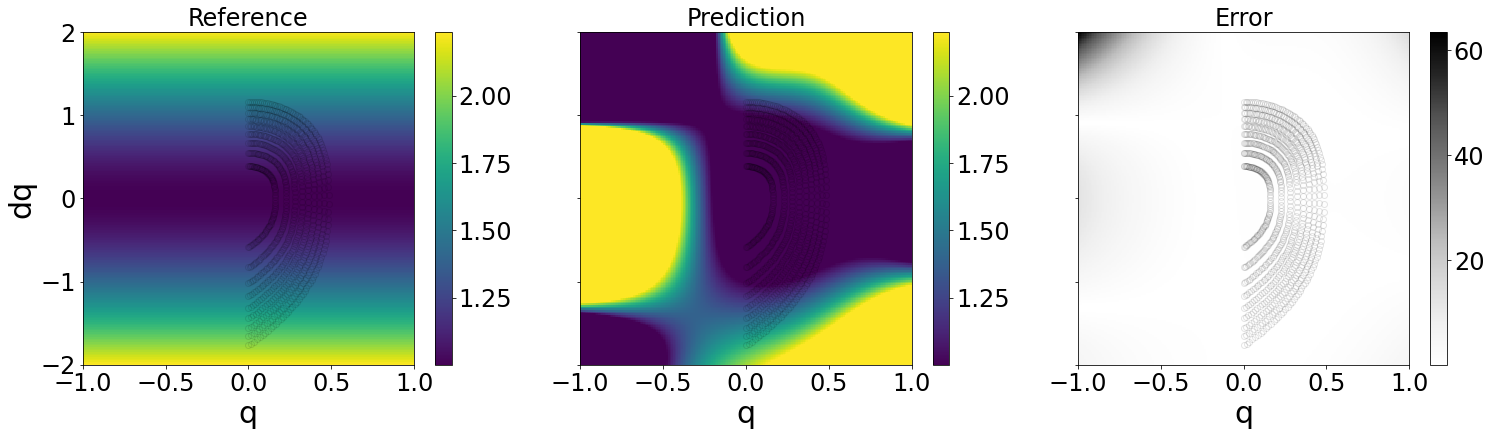

In [24]:
N_test_1d = 200
Lx_test_1d = 1.0
Ly_test_1d = 2.0
N_test = N_test_1d**2

x1_test_1d = np.linspace(-Lx_test_1d, Lx_test_1d, N_test_1d)
x2_test_1d = np.linspace(-Ly_test_1d, Ly_test_1d, N_test_1d)
X_test_2d, Y_test_2d = np.meshgrid(x1_test_1d, x2_test_1d)
Z_test_2d = np.zeros(N_test)

# for nn_save_name in ["diffusivity.dic", "flux.dic", "source.dic"]:
for nn_save_name in ["diffusivity.dic"]:
    if nn_save_name  == "diffusivity.dic":
        x_test =  generate_feature_powers(powers, X_test_2d.reshape(-1), Y_test_2d.reshape(-1))      
        y_test = permeability_ref(x_test).reshape((N_test, 1))
#         trained_net = torch.load(nn_save_name)
        scale = mu_scale
    elif nn_save_name  == "flux.dic":
        x_test = generate_feature_powers(powers, X_test_2d.reshape(-1), Y_test_2d.reshape(-1))     
        y_test = flux_ref(x_test).reshape((N_test, 1))
        trained_net = torch.load(nn_save_name)
        scale = flux_scale
    elif nn_save_name  == "source.dic":
        x_test = generate_feature_powers(powers, X_test_2d.reshape(-1), Y_test_2d.reshape(-1), Z_test_2d)
        y_test = source_ref(x_test).reshape((N_test, 1))
        trained_net = torch.load(nn_save_name)
        scale = source_scale
    else:
        print("nn_save_name : ", nn_save_name, " is not recognized")
        



    y_pred = NeuralNet.net_eval(net=trained_net, x=x_test, mu_scale=scale, non_negative=False, filter_on=False, filter_sigma=filter_sigma, n_data=N_test_1d)  

    y_test_2d = y_test.reshape((N_test_1d,N_test_1d))
    y_pred_2d = y_pred.reshape((N_test_1d,N_test_1d))


    fig, ax = plt.subplots(ncols=3, sharey=True, nrows=1, figsize=((22,6)))

    for j in range(3):
        for i in range(q.shape[0]):
            ax[j].plot(q[i, :], dq[i, :],  "o", color = "black", fillstyle="none", alpha=0.1)
            ax[j].set_xlabel("q")
            if j == 0:
                ax[j].set_ylabel("dq")


    vmin, vmax = y_test_2d.min(), y_test_2d.max()
    im0=ax[0].pcolormesh(X_test_2d, Y_test_2d, y_test_2d, vmin=vmin, vmax=vmax)
    fig.colorbar(im0, ax=ax[0])
    ax[0].set_title("Reference")

    im1=ax[1].pcolormesh(X_test_2d, Y_test_2d, y_pred_2d, vmin=vmin, vmax=vmax)
    fig.colorbar(im1, ax=ax[1])
    ax[1].set_title("Prediction")

    im2=ax[2].pcolormesh(X_test_2d, Y_test_2d, np.abs(y_test_2d - y_pred_2d), cmap = "Greys")
    fig.colorbar(im2, ax=ax[2])
    ax[2].set_title("Error")



    fig.subplots_adjust(bottom=0.15,top=0.92,left=0.08,right=0.97)



In [25]:
def nummodel(permeability, q, yy, res):
    
    Ny = yy.size
    dy = yy[1] - yy[0]
    dq_c = gradient_first_f2c(q, dy)
    q_c = interpolate_f2c(q)
    x = generate_feature_powers(powers, q_c, dq_c)
    mu_c = permeability(x = x)
    res[:] = gradient_first_c2f(mu_c*(dq_c), dy)

# dM/dx    
def nummodel_flux(flux, q, yy, res):
    
    Ny = yy.size
    dy = yy[1] - yy[0]
    dq_c = gradient_first_f2c(q, dy)
    q_c = interpolate_f2c(q)
    x = generate_feature_powers(powers, q_c, dq_c)
    M_c = flux(x = x)
    res[:] = gradient_first_c2f(M_c, dy)

    
def nummodel_source(source, q, yy, res):
    
    Ny = yy.size
    dy = yy[1] - yy[0]
    dq = gradient_first(q, dy)
    ddq = gradient_first(dq, dy)
    x = generate_feature_powers(powers, q, dq, ddq)
    S_f = source(x = x)
    res[:] = S_f[1:-1]

100000 max q 0.3843718214113983
200000 max q 0.3844047417507264
300000 max q 0.38440474223853827
400000 max q 0.3844047422379194
500000 max q 0.38440474223844184
100000 max q 0.5156161708830824
200000 max q 0.5156180304159794
300000 max q 0.5156180304356762
400000 max q 0.5156180304321981
500000 max q 0.5156180304301348
100000 max q 0.2326726373387473
200000 max q 0.2326663206774472
300000 max q 0.23266631651110478
400000 max q 0.2326663165120357
500000 max q 0.23266631651029432


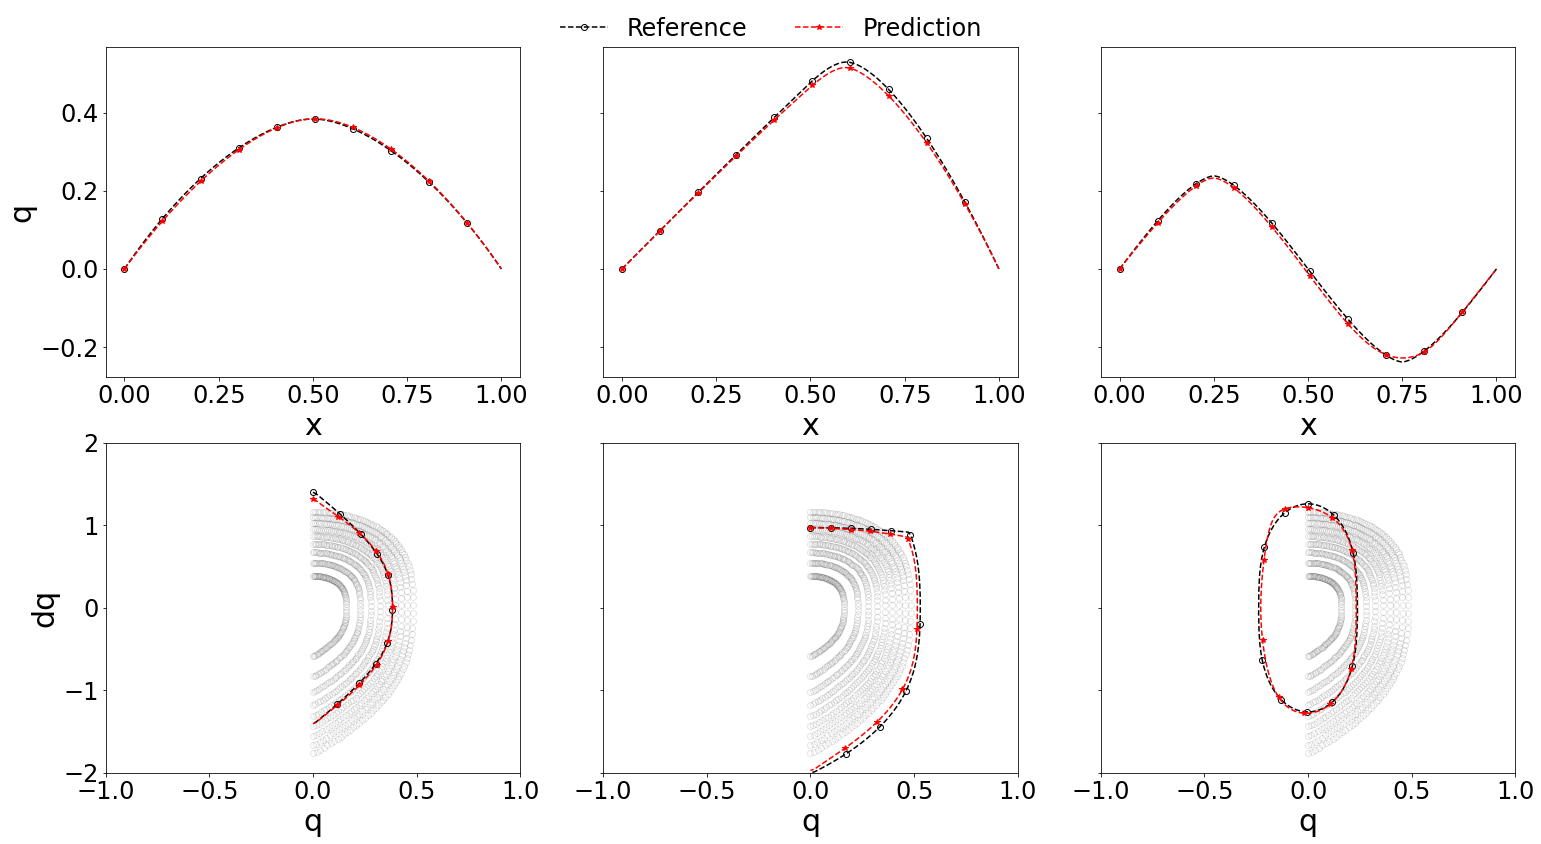

In [26]:
L, Nx =1.0, 100
xx = np.linspace(0.0, L, Nx)
dx = xx[1] - xx[0]
dbc = np.array([0.0, 0.0])  
def f_func1(xx_test):
    return 6*(1-2*xx_test)**2 - 2*(xx_test - xx_test**2)*(1 - 2*xx_test)**2 + 2*(xx_test - xx_test**2)**2 + 2

def f_func2(xx_test):
    f = np.ones_like(xx_test)
    f[xx_test <= 0.5] = 0.0
    f[xx_test > 0.5] = 10.0
    return f

def f_func3(xx_test):
    L = 1
    return 10*np.sin(2*np.pi*xx_test/L)

f_funcs = [f_func1, f_func2, f_func3]


for nn_save_name in ["diffusivity.dic"]:
# for nn_save_name in ["source.dic", "diffusivity.dic", "flux.dic"]:
#     trained_net = torch.load(nn_save_name)



    fig, ax = plt.subplots(ncols=3, nrows=2, sharey="row", figsize=((22,12)))

    for i in range(3):

        f_func = f_funcs[i]
        f = f_func(xx)   
        filter_on = False
        if nn_save_name  == "diffusivity.dic":
            nn_model = partial(NeuralNet.nn_viscosity, net=trained_net, mu_scale = mu_scale, non_negative=True, filter_on=filter_on, filter_sigma=filter_sigma)
            model = lambda q, yy, res : nummodel(nn_model, q, yy, res)
        elif nn_save_name  == "flux.dic":
            nn_model = partial(NeuralNet.nn_viscosity, net=trained_net, mu_scale = flux_scale, non_negative=False, filter_on=filter_on, filter_sigma=filter_sigma)
            model = lambda q, yy, res : nummodel_flux(nn_model, q, yy, res)
        elif nn_save_name  == "source.dic":
            nn_model = partial(NeuralNet.nn_viscosity, net=trained_net, mu_scale = source_scale, non_negative=False, filter_on=filter_on, filter_sigma=filter_sigma)
            model = lambda q, yy, res : nummodel_source(nn_model, q, yy, res)
        else:
            print("nn_save_name : ", nn_save_name, " is not recognized")
            
            
            
        _, _, q_data = explicit_solve(model, f, dbc, dt = 5.0e-6, Nt = 500000, save_every = 100000, L = L)
        q_pred = q_data[-1, :]
        dq_pred  = Numerics.gradient_first(q_pred, dy, bc = "one-sided")


        ax[0,i].plot(xx_test[i,:], q_test[i,:],  "--o", color="black", fillstyle="none", label="Reference", markevery=10)
        ax[0,i].plot(xx_test[i,:], q_pred,  "--*", color="red", label="Prediction", markevery=10)
        if i == 0:
            ax[0,i].set_ylabel("q")
        ax[0,i].set_xlabel("x")

        for j in range(q.shape[0]):
            ax[1,i].plot(q[j, :], dq[j, :],  "o", color = "black", fillstyle="none", alpha=0.1)

        ax[1,i].plot(q_test[i,:], dq_test[i,:],  "--o", color="black", fillstyle="none", label="Reference", markevery=10)
        ax[1,i].plot(q_pred, dq_pred,  "--*", color="red", label="Prediction", markevery=10)
        ax[1,i].set_xlim([-1,1])
        ax[1,i].set_ylim([-2,2])
        if i == 0:
            ax[1,i].set_ylabel("dq")
        ax[1,i].set_xlabel("q")


    
    

    
handles, labels = ax[0,0].get_legend_handles_labels()
fig.subplots_adjust(bottom=0.08,top=0.92,left=0.08,right=0.97)
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.98),ncol=2,frameon=False)



In [27]:
fig.savefig("Poisson-Dict.pdf")